#Pipeline to train a Unet model with attention Gates.
Here we'll be using a Unet model with 5 blocks and pair of images (post and pre) as inputs.

##Useful imports

In [ ]:
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
#import cv2

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import ToTensor
import torch.nn as nn
from tqdm.contrib.telegram import tqdm, trange
from torchvision.io import read_image
import torchvision.transforms.functional as transform
from torchvision.transforms.transforms import Resize
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import random
from torch.optim.lr_scheduler import StepLR, MultiStepLR
from torch.autograd import Variable
import datetime, os
import torchvision.transforms.functional as TF
import torchvision


In [ ]:
pip install -q -U segmentation-models-pytorch albumentations

##Gdrive import + PATHS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMG_PATH = '/content/drive/My Drive/natural_catastroph_folder/training_dataset/images'
MASK_PATH = '/content/drive/My Drive/natural_catastroph_folder/training_dataset/targets'
CSV_PATH = '/content/drive/My Drive/natural_catastroph_folder/Yanis_folder/notebooks/hurricane_duo.csv'

In [ ]:
TENSORBOARD_LOG_PATH = '/content/drive/My Drive/natural_catastroph_folder/log_files/Unet_logs/'
MODEL_TO_SAVE_PATH = "/content/drive/My Drive/natural_catastroph_folder/Yanis_folder/saved_models/"

##Useful Function

In [ ]:
#Class for avg meter
class AverageMeter:
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

##Our Unet model

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi

    def psi_mask(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return psi


class AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

    def first_attentionGate_mask(self, x):
      # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        psi = self.Att2.psi_mask(g=d2,x=x1)

        return psi

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
"""HERE ONLY 3 CHANNELS NOT 5 BECAUSE WE MERGED SOME CLASSES"""
model = AttU_Net(img_ch=6, output_ch=3).to(device)


name_save_model = "duo-AttUnet_512px_3classes"
path_model = F"/content/drive/My Drive/natural_catastroph_folder/Yanis_folder/saved_models/{name_save_model}"
model.load_state_dict(torch.load(path_model))


<All keys matched successfully>

##Datasets + Dataloaders

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
class ImageDatasetDuoCSV(Dataset):
  def __init__(self,img_folder, mask_folder,csv_path,transform=None, transform_mask=None, std_mean=None):
    self.transform=transform
    self.transform_mask=transform_mask
    self.std_mean=std_mean

    self.img_folder=img_folder
    self.mask_folder=mask_folder

    self.csv_file = pd.read_csv(csv_path)
  
#The __len__ function returns the number of samples in our dataset.
  def __len__(self):
    return len(self.csv_file)

  def __getitem__(self,index):
    img_pre_name = self.csv_file['img_pre'].iloc[index]
    mask_pre_name = self.csv_file['mask_pre'].iloc[index]
    img_post_name = self.csv_file['img_post'].iloc[index]
    mask_post_name = self.csv_file['mask_post'].iloc[index]

    img_pre = read_image(self.img_folder+'/'+img_pre_name).type(torch.FloatTensor)
    img_post = read_image(self.img_folder+'/'+img_post_name).type(torch.FloatTensor)

    #mask_pre = read_image(self.mask_folder+'/'+mask_pre_name).type(torch.LongTensor)
    mask_post = read_image(self.mask_folder+'/'+mask_post_name).type(torch.LongTensor)

    """
    IF WE WANT TO HAVE ONLY 3 CLASSES --> Background(0), No-damage(1) and Damage(2)
    DONT FORGET TO CHANGE THE NUMBER OF CHANNELS IN THE MODEL
    """

    mask_post[mask_post==2] = 1
    mask_post[mask_post==3] = 2
    mask_post[mask_post==4] = 2

    #MANUAL TRANSFORMS:
    if self.std_mean != None:
      normalize = transforms.Normalize(mean=std_mean[1], std=std_mean[0])
    else: 
      normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    img_pre = normalize(img_pre)
    img_post = normalize(img_post)

    resize = transforms.Resize(size=(512, 512))

    img_pre = resize(img_pre)
    img_post = resize(img_post)

    #mask_pre = resize(mask_pre)
    mask_post = resize(mask_post)

    image = torch.concat((img_pre, img_post), 0)
    #mask = torch.concat((mask_pre, mask_post), 0)
    mask = mask_post

    return image, mask


In [ ]:
TRAIN_TRANSFORMS = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.3),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],)
])

TRAIN_MASK_TRANSFORMS = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [ ]:
def split_dataset(dataset, ratio):
    length1 = int(len(dataset) * ratio)
    length2 = len(dataset) - length1
    lengths = [length1, length2]
    return random_split(dataset, lengths)

In [ ]:
dataset = ImageDatasetDuoCSV(IMG_PATH, MASK_PATH, CSV_PATH)
train_dataset, valid_dataset = split_dataset(dataset, 0.7)


print(f"Length of train dataset: {len(train_dataset):,}")
print(f"Length of valid dataset: {len(valid_dataset):,}")

Length of train dataset: 853
Length of valid dataset: 366


In [ ]:
BATCH_SIZE = 4


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Generate Weights for our loss

In [ ]:
mask_to_weight_list = []
#image_to_weight_list = []
counter = 0

for image, mask_to_weight in train_dataloader:
  #image_to_weight_list.append(image)

  if counter %10 ==0:
    mask_to_weight_list.append(mask_to_weight)
  counter += 1


counter = 0

for image, mask_to_weight in valid_dataloader:
  mask_to_weight_list.append(mask_to_weight)
  #image_to_weight_list.append(image)
  if counter %10 ==0:
    mask_to_weight_list.append(mask_to_weight)
  counter += 1


mask_to_weight_list = torch.cat(mask_to_weight_list, dim=0)
#image_to_weight_list = torch.cat(image_to_weight_list, dim=0)

In [ ]:
#### TEST STD MEAN

In [ ]:
#std_mean = torch.std_mean(image_to_weight_list, unbiased=False)

In [ ]:
#dataset = ImageDatasetCSV(IMG_PATH, MASK_PATH, CSV_PATH, std_mean=std_mean)

#train_dataset, valid_dataset = split_dataset(dataset, 0.7)
#train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
#### TEST STD MEAN end

In [ ]:
np.unique(mask_to_weight_list)

array([0, 1, 2])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights=compute_class_weight(class_weight='balanced',classes=np.unique(mask_to_weight_list),y=mask_to_weight_list.flatten().cpu().numpy())
class_weights=torch.tensor(class_weights,dtype=torch.float)

print(class_weights)

tensor([ 0.3554,  6.8005, 25.4723])


In [ ]:
#We get better results by using these following weights
#Indeed since the label=2 is very uncommon we compute a weight of 25, which completely distort our loss
class_weights = torch.Tensor([0.3793, 3, 3])

##Criterion + Optimizer + Scheduler

In [ ]:
#criterion = nn.CrossEntropyLoss().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights,reduction='mean').to(device)
#criterion = smp.utils.losses.DiceLoss()

LR = 1e-4

optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:
LR_STEPS = [20, 40, 60, 100]
GAMMA = 0.1
scheduler = MultiStepLR(optimizer, milestones=LR_STEPS, gamma=GAMMA)
EPOCHS=100

##TensorBoard


In [ ]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard



In [ ]:
current_time = "duo-Attunet-1024px-3c-" + str(datetime.datetime.now().timestamp()) 
log_dir = TENSORBOARD_LOG_PATH + current_time
summary_writer = SummaryWriter(log_dir=log_dir)

In [ ]:
#Open tensorboard
%tensorboard --logdir TENSORBOARD_LOG_PATH

##Training loop

In [ ]:
#Here we need a TOKEN + CHAT_ID because we're using a special tqdm
#Indeed this tqdm allows us to monitor our training directly on our phone thanks to a telegram bot
TOKEN = '5170567570:AAGQ5rRaWRzXTFd4f-nDUpUtBC1COqr3WOY'
CHAT_ID = '2043389793'

In [ ]:
best_loss = 1e+10

loss_training_list = []
loss_validation_list = []

acc_training_list = []
acc_validation_list = []

iou_metric = smp.utils.metrics.IoU(threshold=0.5)


epoch_bar = tqdm(range(EPOCHS), total=EPOCHS, desc="Epochs", position=0, leave=True, token=TOKEN, chat_id=CHAT_ID)
for epoch in epoch_bar:  # loop over the dataset multiple times
    # Train the model
    model.train()
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top1_bis = AverageMeter('Acc@1', ':6.2f')

    running_loss = 0.0
    training_bar = tqdm(train_dataloader, total=len(train_dataloader), desc="Training", position=0, leave=True, token=TOKEN, chat_id=CHAT_ID)

    for image, mask in training_bar:

        image = image.to(device)
        mask = mask.to(device)

        # forward + backward + optimize
        outputs = model(image)

        #CE Loss:
        loss = criterion(outputs, mask.squeeze(1))

        #Dice Loss
        #loss = criterion(outputs, mask)

        # zero the parameter gradients
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        losses.update(loss.item(), image.size(0))

        """
        #Acc
        intersection = np.logical_and(mask.cpu().detach().numpy(), torch.ceil(outputs).cpu().detach().numpy())
        union = np.logical_or(mask.cpu().detach().numpy(), torch.ceil(outputs).cpu().detach().numpy())
        iou_score = np.sum(intersection) / np.sum(union)
        top1.update(iou_score.item(), image.size(0))
        """
        #Acc 2
        predictions = torch.nn.functional.softmax(outputs, dim=1)
        pred_labels = torch.argmax(predictions, dim=1) 

        iou_score_bis = iou_metric.forward(mask, pred_labels)
        top1_bis.update(iou_score_bis.item(), image.size(0))

        training_bar.set_postfix({"loss": f"{loss:.3f}", "acc": f"{iou_score_bis:.3f}"})

    epoch_bar.set_postfix({f"loss": f"{losses.avg:.6f}"})
    print(f"\nTraining, Loss: {losses.avg:.3f}")
    print(f"Training, Acc: {top1.avg:.3f}")
    print("\n")

    loss_training_list.append(losses.avg)
    acc_training_list.append(top1.avg)
    summary_writer.add_scalar("Training/Loss", losses.avg, epoch)
    summary_writer.add_scalar("Training/Acurracy", top1_bis.avg, epoch)

    scheduler.step()

    # Validation
    losses.reset()
    top1.reset()
    top1_bis.reset()

    model.eval()
    valid_pbar = tqdm(valid_dataloader, total=len(valid_dataloader), desc="Validation", position=0, leave=True, token=TOKEN, chat_id=CHAT_ID)
    with torch.no_grad():
        for image, mask in valid_pbar:

            image = image.to(device)
            mask = mask.to(device)

            outputs = model(image)

            #CE Loss:
            loss = criterion(outputs, mask.squeeze(1))

            #Dice Loss
            #loss = criterion(outputs, mask)

            losses.update(loss.item(), image.size(0))
            """
            #Acc
            intersection = np.logical_and(mask.cpu().detach().numpy(), torch.ceil(outputs).cpu().detach().numpy())
            union = np.logical_or(mask.cpu().detach().numpy(), torch.ceil(outputs).cpu().detach().numpy())
            iou_score = np.sum(intersection) / np.sum(union)
            top1.update(iou_score.item(), image.size(0))
            """
            #Acc 2
            predictions = torch.nn.functional.softmax(outputs, dim=1)
            pred_labels = torch.argmax(predictions, dim=1) 

            iou_score_bis = iou_metric.forward(mask, pred_labels)

            top1_bis.update(iou_score_bis.item(), image.size(0))

            valid_pbar.set_postfix({f"loss": f"{loss:.3f}", "acc": f"{iou_score_bis:.3f}"})

        print(f"\nValidation, Loss: {losses.avg:.3f}")
        print(f"Validation, Acc: {top1.avg:.3f}")
        loss_validation_list.append(losses.avg)
        acc_validation_list.append(top1.avg)
        summary_writer.add_scalar("Validation/Loss", losses.avg, epoch)
        summary_writer.add_scalar("Validation/Acurracy", top1_bis.avg, epoch)

        if best_loss > losses.avg:
          name_save_model = "duo-AttUnet_1024px_3classes"
          path_model = MODEL_TO_SAVE_PATH + name_save_model
          torch.save(model.state_dict(), path_model)
          print('Model saved!')
          best_loss = losses.avg

    print("\n")
print('Finished Training')

##Display real and generated masks

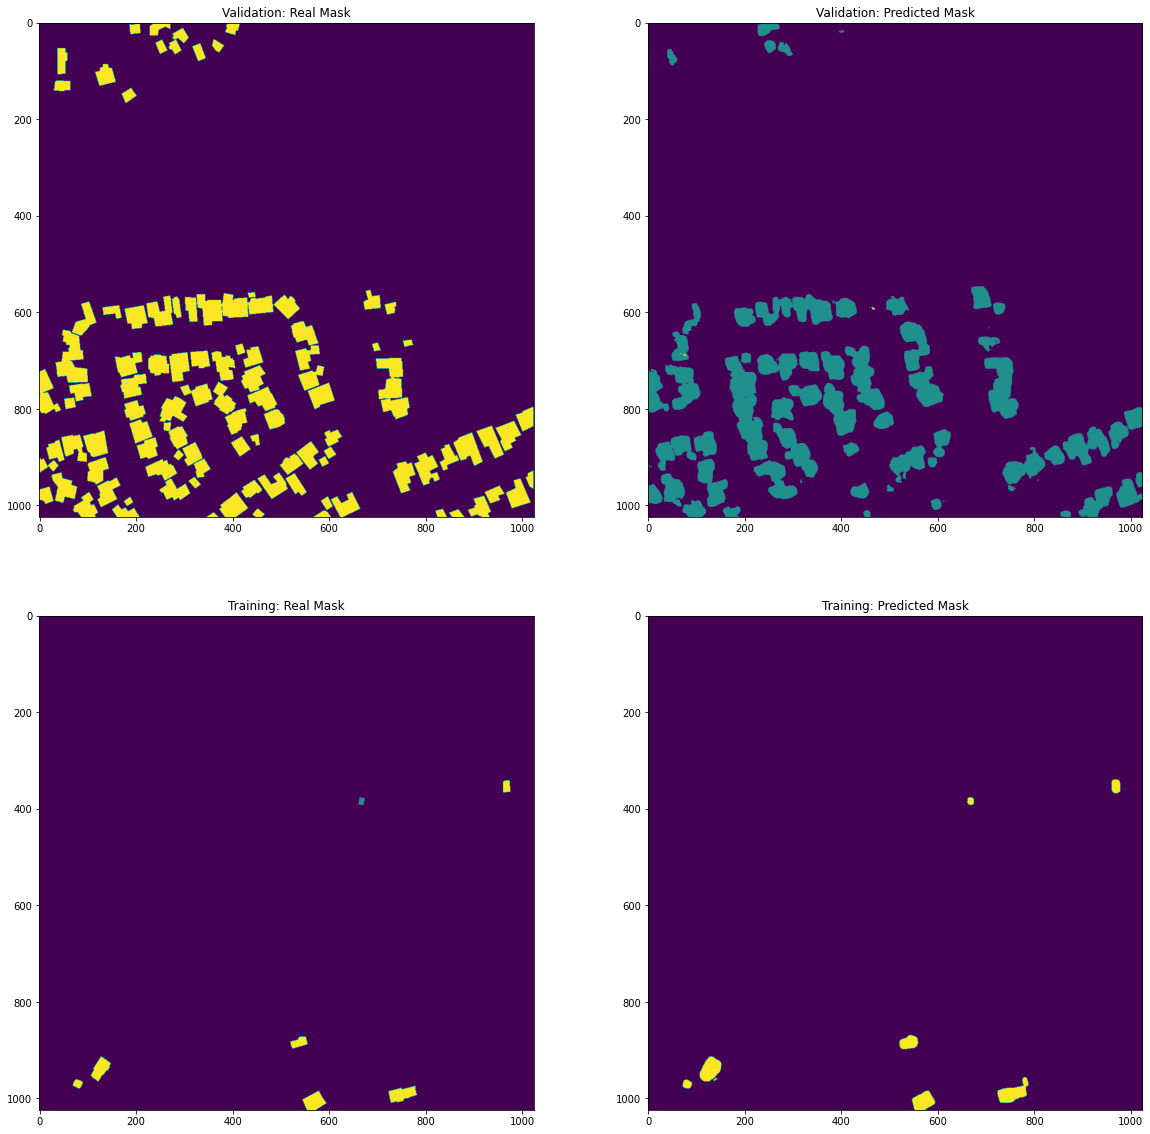

In [ ]:
#Display real and generated mask
model.eval()
with torch.no_grad():
  image, mask = next(iter(valid_dataloader))

  image, mask = image.to(device), mask.to(device)
  predictions = model(image) 
  
  predictions = torch.nn.functional.softmax(predictions, dim=1)
  pred_labels = torch.argmax(predictions, dim=1) 
  pred_labels = pred_labels.float()

  # Remapping the labels
  #pred_labels = pred_labels.to('cpu')
  #pred_labels.apply_(lambda x: t2l[image].id)
  pred_labels = pred_labels.to(device)   

  # Resizing predicted images too original size
  #pred_labels = transforms.Resize((1024, 1024))(pred_labels)  

  ##################################################################################
  image_train, mask_train = next(iter(train_dataloader))

  image_train, mask_train = image_train.to(device), mask_train.to(device)
  predictions_train = model(image_train) 
  
  predictions_train = torch.nn.functional.softmax(predictions_train, dim=1)
  pred_labels_train = torch.argmax(predictions_train, dim=1) 
  pred_labels_train = pred_labels_train.float()

  pred_labels_train = pred_labels_train.to(device)           

#########
plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(2,2)

#Real mask
axarr[0, 0].set_title('Validation: Real Mask',)
axarr[0, 0].imshow(mask[0].detach().cpu().squeeze())

#Predicted mask
axarr[0, 1].set_title('Validation: Predicted Mask',)
axarr[0, 1].imshow(pred_labels[0].detach().cpu().squeeze())

################################
#Real mask TRAIN
axarr[1, 0].set_title('Training: Real Mask',)
axarr[1, 0].imshow(mask_train[0].detach().cpu().squeeze())

#Predicted mask TRAIN
axarr[1, 1].set_title('Training: Predicted Mask',)
axarr[1, 1].imshow(pred_labels_train[0].detach().cpu().squeeze())


plt.show()



##Code to fix CUDA ERRORS

In [ ]:
import gc

gc.collect()


torch.cuda.empty_cache()